# Demonstration 2: Approach-Avoidance Tasks

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sisyphus.envs import BART, SleepingPredator
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
img_dir = os.path.join('..','figures')
%matplotlib inline

## Task: Balloon Analog Risk Task

### Value Iteration

In [2]:
from sisyphus.mdp import ValueIteration

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
weights = [1.0, 0.6, 0.2]

## Environment parameters.
pumps = 20
means = [16, 8] 
sd = 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

policy = []
for mu in means:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Environment setup.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize environment.
    gym = BART(pumps=pumps, mu=mu, sd=sd)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Value iteration.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Iterate over weights.
    for j, w in enumerate(weights):
    
        ## Initialize value iteration.
        qvi = ValueIteration(policy='pessimism', gamma=1.0, w=w)

        ## Solve for Q-values.
        qvi = qvi.fit(gym)

        ## Solve for policy.
        pi = qvi.pi
        n_pumps = len(pi) - 1
                
        ## Store policy.
        policy.append( n_pumps )

## Task: Sleeping Predator Task

### Value Iteration

In [3]:
from sisyphus.mdp import ValueIteration

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
weights = [1.0, 0.6, 0.2]

## Environment parameters.
risk = [0.1, 0.15]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

relval = []
for p in risk:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Environment setup.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize environment.
    gym = SleepingPredator(p=p)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Value iteration.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Iterate over weights.
    for j, w in enumerate(weights):
    
        ## Initialize value iteration.
        qvi = ValueIteration(policy='pessimism', gamma=1.0, w=w)

        ## Solve for Q-values.
        qvi = qvi.fit(gym)
        
        ## Compute Go - NoGo.
        delta = np.diff( qvi.Q[:12].reshape(6,2) )
        delta *= -1    # Make Go - NoGo
        
        ## Store relative value.
        relval.append(delta)

## Plotting

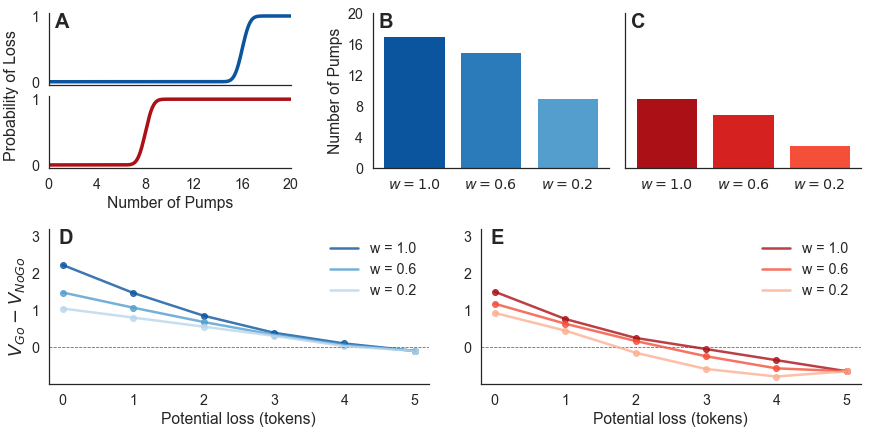

In [4]:
from scipy.stats import norm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define layout.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize figure.
fig = plt.figure(figsize=(12,6))

## Define palettes.
blues = sns.color_palette('Blues_r', n_colors=6).as_hex()
reds = sns.color_palette('Reds_r', n_colors=6).as_hex()

## Canvas 1: BART environment.
gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0.05, right=0.33, bottom=0.61, top=0.97, hspace=0.15, wspace=0)

## Canvas 2: BART results.
gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.425, right=0.99, bottom=0.61, top=0.97, hspace=0, wspace=0.07)

## Canvas 3: Predator results (low risk).
gs3 = gridspec.GridSpec(1,1)
gs3.update(left=0.05, right=0.49, bottom=0.11, top=0.47, hspace=0.15, wspace=0)

## Canvas 4: Predator results (high risk).
gs4 = gridspec.GridSpec(1,1)
gs4.update(left=0.55, right=0.99, bottom=0.11, top=0.47, hspace=0, wspace=0.0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### BART Environment.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, palette in enumerate([blues, reds]):

    ## Initialize canvas.
    ax = plt.subplot(gs1[i])
    x = np.linspace(0,pumps,1000)    

    ## Plot risk.
    ax.plot(x, norm(means[i],sd).cdf(x), color=palette[0], lw=3.5)
    ax.set(xlim=(0,pumps), xticks=[], yticks=[0,1])

    ## Add details.
    if not i: ax.annotate('A', (0,0), (0.025,1), 'axes fraction', fontsize=20, 
                          fontweight='bold', ha='left', va='top')
    else: ax.set(xticks=np.arange(0,pumps+1,4), xlabel='Number of Pumps')
        
## Add joint label.
ax.annotate('Probability of Loss', (0,0), (0.005,0.78), 'figure fraction', rotation=90, 
            fontsize=16, ha='left', va='center')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### BART Results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Low risk environment.
ax = plt.subplot(gs2[0])
ax.bar(np.arange(3), policy[:3], color=blues[:3])
ax.set(xticks=[0,1,2], xticklabels=['$w = %0.1f$' %w for w in weights], ylim=(0,pumps),
       yticks=np.arange(0,pumps+1,4), ylabel='Number of Pumps')
ax.annotate('B', (0,0), (0.025,1), 'axes fraction', fontsize=20, fontweight='bold', ha='left', va='top')

## High risk environment.
ax = plt.subplot(gs2[1])
ax.bar(np.arange(3), policy[3:], color=reds[:3])
ax.set(xticks=[0,1,2], xticklabels=['$w = %0.1f$' %w for w in weights], ylim=(0,pumps), yticks=[])
ax.annotate('C', (0,0), (0.025,1), 'axes fraction', fontsize=20, fontweight='bold', ha='left', va='top')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Predator results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Low risk environment.
ax = plt.subplot(gs3[0])
for i, (delta, w) in enumerate(zip(relval[:3], weights)):
    ax.plot(delta, lw=2.5, color=blues[i*2], label='w = %0.1f' %w, alpha=0.8)
    ax.scatter(np.arange(6), delta, color=blues[i*2], alpha=0.8)
ax.hlines(0, -0.2, 5.2, color='0.4', lw=0.8, linestyle='--')
ax.set(xlim=(-0.2, 5.2), xlabel='Potential loss (tokens)', ylim=(-1,3.2), yticks=[0,1,2,3])
ax.set_ylabel(r'$V_{Go} - V_{NoGo}$', fontsize=18)
ax.annotate('D', (0,0), (0.025,1), 'axes fraction', fontsize=20, fontweight='bold', ha='left', va='top')
ax.legend(loc=1, frameon=False)
    
## High risk environment.
ax = plt.subplot(gs4[0])
for i, (delta, w) in enumerate(zip(relval[3:], weights)):
    ax.plot(delta, lw=2.5, color=reds[i*2], label='w = %0.1f' %w, alpha=0.8)
    ax.scatter(np.arange(6), delta, color=reds[i*2], alpha=0.8)
ax.hlines(0, -0.2, 5.2, color='0.4', lw=0.8, linestyle='--')
ax.set(xlim=(-0.2, 5.2), xlabel='Potential loss (tokens)', ylim=(-1,3.2), yticks=[0,1,2,3])
ax.annotate('E', (0,0), (0.025,1), 'axes fraction', fontsize=20, fontweight='bold', ha='left', va='top')
ax.legend(loc=1, frameon=False)
    
sns.despine()
plt.savefig(os.path.join(img_dir, '02_appavo.png'), dpi=300)